In [1]:
from loss import MSELoss, CrossEntropyLoss
from sgd import SGD
from linear import Linear
from sequential import Sequential
from activation import ReLU, Tanh
from math import pi
from torch import empty, set_grad_enabled
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


In [2]:
import torch
import math

from torch import optim
from torch import Tensor
from torch import nn

In [3]:

def generate_disc_set(nb, one_hot=False):
    #input = empty(nb, 2).uniform_(-1, 1)
    #target = input.pow(2).sum(1).sub(2 / pi).sign().add(1).div(2).long()
    input = empty(nb, 2).uniform_(0, 1)
    target = input.add(-0.5).pow(2).sum(1).sub(1 /(2*pi)).sign().add(1).div(2).long()
    if not one_hot:
        target = target.new_zeros(
            target.size(0), 
            input.size(1)).scatter(1, target.view(-1, 1), 1)
    return input, target

###############################################################################

def compute_nb_errors(model, data_input, data_target, mini_batch_size=100, one_hot=False):
    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(axis=1)
        for k in range(mini_batch_size):
            target = data_target[b + k]
            if not one_hot:
                target = target.argmax()
            if target != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors


def train_model(model, train_input, train_target, it, mini_batch_size=100, one_hot=False):
    creterion = MSELoss(model) if not one_hot else CrossEntropyLoss(model)
    optimizer = SGD(model.parameters(), lr=5e-2, momentum=0.5)
    nb_epochs = 100
    l = []

    for _ in tqdm(range(nb_epochs)):
        batch_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = creterion(output, train_target.narrow(0, b, mini_batch_size))
            
            model.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = loss + batch_loss
        l.append(batch_loss)
    matrix_loss_our[:,it] = l
    #plt.plot(range(nb_epochs), l, label = 'Our Class')

    
    
def train_model2(model, train_input, train_target, it):
    train_input = train_input.to(torch.float32)
    train_target = train_target.to(torch.float32)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr = 1e-1)
    nb_epochs = 100

    l = []
    for _ in tqdm(range(nb_epochs)):
        batch_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss = loss + batch_loss
        l.append(batch_loss)
    matrix_loss_pytorch[:,it] = l

        #plt.plot(range(nb_epochs), l, label = 'Pytorch')
    
    
    


In [4]:
#Compare performances
import time

num_it = 100
vect_it = np.arange(0,num_it,1)
vect_our_train_errors = np.ones((num_it,1))
vect_our_test_errors = np.ones((num_it,1))
vect_pytorch_train_errors = np.ones((num_it,1))
vect_pytorch_test_errors = np.ones((num_it,1))
matrix_loss_our = np.ones((100, num_it))
matrix_loss_pytorch = np.ones((100, num_it))
vect_time_our = np.ones((num_it, 1))
vect_time_pytorch = np.ones((num_it, 1))

for it in vect_it:
    set_grad_enabled(False)
    one_hot = False
    train_input, train_target = generate_disc_set(1000, one_hot)
    test_input, test_target = generate_disc_set(1000, one_hot)
    mean, std = train_input.mean(), train_input.std()
    train_input.sub_(mean).div_(std)
    test_input.sub_(mean).div_(std)

    time1 = time.time()
    model = Sequential(
        Linear(2, 25),
        ReLU(),
        Linear(25, 2)
    )

    train_model(model, train_input, train_target, it, one_hot=one_hot)
    time2 = time.time()
    print('Our: train_error {:.02f}% test_error {:.02f}%'.format(
           compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100,
            compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100))
    #plt.savefig('prova.png')
    vect_our_train_errors[it] = compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100
    vect_our_test_errors[it] = compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100
    vect_time_our[it] = time2 - time1
    ######################################################################
   
    set_grad_enabled(True)
    #mean, std = train_input.mean(), train_input.std()
    #train_input.sub_(mean).div_(std)
    #test_input.sub_(mean).div_(std)

    mini_batch_size = 100
    time1 = time.time()
    model2 = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 2)
        )
    train_model2(model2, train_input, train_target, it)
    time2 = time.time()
    print('Pytorch: train_error {:.02f}% test_error {:.02f}%'.format(
           compute_nb_errors(model2, train_input, train_target) / train_input.size(0) * 100,
            compute_nb_errors(model2, test_input, test_target) / test_input.size(0) * 100))

    vect_pytorch_train_errors[it] = compute_nb_errors(model2, train_input, train_target) / train_input.size(0) * 100
    vect_pytorch_test_errors[it] = compute_nb_errors(model2, test_input, test_target) / test_input.size(0) * 100
    vect_time_pytorch[it] = time2 - time1

#plt.xlabel('# epochs')
#plt.ylabel('Loss (MSE)')
#plt.legend()
#plt.show()



  0%|          | 0/100 [00:00<?, ?it/s]

Our: train_error 3.30% test_error 4.10%


/home/marti/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
 23%|██▎       | 23/100 [00:00<00:00, 224.38it/s]

Pytorch: train_error 1.90% test_error 3.70%


 14%|█▍        | 14/100 [00:00<00:00, 135.11it/s]

Our: train_error 4.30% test_error 5.40%


 24%|██▍       | 24/100 [00:00<00:00, 233.83it/s]

Pytorch: train_error 3.10% test_error 3.80%


 18%|█▊        | 18/100 [00:00<00:00, 173.45it/s]

Our: train_error 5.00% test_error 5.10%


 19%|█▉        | 19/100 [00:00<00:00, 185.94it/s]

Pytorch: train_error 3.10% test_error 4.00%


 14%|█▍        | 14/100 [00:00<00:00, 137.31it/s]

Our: train_error 2.70% test_error 3.60%


 19%|█▉        | 19/100 [00:00<00:00, 186.10it/s]

Pytorch: train_error 2.60% test_error 3.20%


 19%|█▉        | 19/100 [00:00<00:00, 181.76it/s]

Our: train_error 4.50% test_error 4.10%


 25%|██▌       | 25/100 [00:00<00:00, 246.82it/s]

Pytorch: train_error 3.80% test_error 3.70%


 19%|█▉        | 19/100 [00:00<00:00, 182.91it/s]

Our: train_error 3.50% test_error 4.50%


 17%|█▋        | 17/100 [00:00<00:00, 167.85it/s]

Pytorch: train_error 2.80% test_error 4.40%


 19%|█▉        | 19/100 [00:00<00:00, 189.91it/s]

Our: train_error 4.10% test_error 4.20%


 25%|██▌       | 25/100 [00:00<00:00, 248.07it/s]

Pytorch: train_error 2.60% test_error 3.40%


 19%|█▉        | 19/100 [00:00<00:00, 189.08it/s]

Our: train_error 4.00% test_error 4.90%


 24%|██▍       | 24/100 [00:00<00:00, 239.12it/s]

Pytorch: train_error 2.70% test_error 3.50%


 19%|█▉        | 19/100 [00:00<00:00, 187.54it/s]

Our: train_error 4.10% test_error 3.70%


 25%|██▌       | 25/100 [00:00<00:00, 248.59it/s]

Pytorch: train_error 3.40% test_error 3.30%


 19%|█▉        | 19/100 [00:00<00:00, 182.31it/s]

Our: train_error 4.10% test_error 5.50%


 25%|██▌       | 25/100 [00:00<00:00, 247.02it/s]

Pytorch: train_error 2.10% test_error 2.50%


 19%|█▉        | 19/100 [00:00<00:00, 188.79it/s]

Our: train_error 4.30% test_error 5.20%


 25%|██▌       | 25/100 [00:00<00:00, 248.23it/s]

Pytorch: train_error 1.90% test_error 2.20%


 20%|██        | 20/100 [00:00<00:00, 191.54it/s]

Our: train_error 4.60% test_error 4.60%


 25%|██▌       | 25/100 [00:00<00:00, 247.56it/s]

Pytorch: train_error 3.30% test_error 3.80%


 19%|█▉        | 19/100 [00:00<00:00, 182.69it/s]

Our: train_error 3.20% test_error 2.80%


 25%|██▌       | 25/100 [00:00<00:00, 247.05it/s]

Pytorch: train_error 1.80% test_error 3.00%


 20%|██        | 20/100 [00:00<00:00, 191.29it/s]

Our: train_error 4.00% test_error 4.20%


 25%|██▌       | 25/100 [00:00<00:00, 248.24it/s]

Pytorch: train_error 2.00% test_error 2.40%


 19%|█▉        | 19/100 [00:00<00:00, 188.69it/s]

Our: train_error 4.10% test_error 4.50%


 25%|██▌       | 25/100 [00:00<00:00, 249.33it/s]

Pytorch: train_error 3.40% test_error 4.90%


 20%|██        | 20/100 [00:00<00:00, 190.41it/s]

Our: train_error 2.60% test_error 3.60%


 25%|██▌       | 25/100 [00:00<00:00, 247.85it/s]

Pytorch: train_error 2.20% test_error 3.80%


 19%|█▉        | 19/100 [00:00<00:00, 189.14it/s]

Our: train_error 3.50% test_error 4.70%


 25%|██▌       | 25/100 [00:00<00:00, 247.91it/s]

Pytorch: train_error 1.90% test_error 2.30%


 20%|██        | 20/100 [00:00<00:00, 191.04it/s]

Our: train_error 4.50% test_error 4.40%


 25%|██▌       | 25/100 [00:00<00:00, 248.08it/s]

Pytorch: train_error 1.90% test_error 1.70%


 20%|██        | 20/100 [00:00<00:00, 190.84it/s]

Our: train_error 4.40% test_error 4.10%


 25%|██▌       | 25/100 [00:00<00:00, 241.21it/s]

Pytorch: train_error 5.50% test_error 4.90%


 19%|█▉        | 19/100 [00:00<00:00, 183.49it/s]

Our: train_error 4.50% test_error 4.40%


 25%|██▌       | 25/100 [00:00<00:00, 249.12it/s]

Pytorch: train_error 1.60% test_error 2.20%


 19%|█▉        | 19/100 [00:00<00:00, 187.35it/s]

Our: train_error 2.90% test_error 3.00%


 25%|██▌       | 25/100 [00:00<00:00, 249.58it/s]

Pytorch: train_error 2.10% test_error 2.40%


 19%|█▉        | 19/100 [00:00<00:00, 188.34it/s]

Our: train_error 2.90% test_error 4.00%


 25%|██▌       | 25/100 [00:00<00:00, 240.47it/s]

Pytorch: train_error 2.50% test_error 4.00%


 19%|█▉        | 19/100 [00:00<00:00, 181.02it/s]

Our: train_error 3.70% test_error 4.90%


 26%|██▌       | 26/100 [00:00<00:00, 250.16it/s]

Pytorch: train_error 1.10% test_error 2.40%


 20%|██        | 20/100 [00:00<00:00, 190.79it/s]

Our: train_error 2.50% test_error 3.00%


 25%|██▌       | 25/100 [00:00<00:00, 248.47it/s]

Pytorch: train_error 2.50% test_error 2.60%


 20%|██        | 20/100 [00:00<00:00, 191.17it/s]

Our: train_error 2.90% test_error 5.00%


 23%|██▎       | 23/100 [00:00<00:00, 227.10it/s]

Pytorch: train_error 2.10% test_error 3.30%


 18%|█▊        | 18/100 [00:00<00:00, 171.81it/s]

Our: train_error 4.10% test_error 6.60%


 22%|██▏       | 22/100 [00:00<00:00, 213.57it/s]

Pytorch: train_error 2.40% test_error 2.50%


 12%|█▏        | 12/100 [00:00<00:00, 119.10it/s]

Our: train_error 5.30% test_error 5.00%


 22%|██▏       | 22/100 [00:00<00:00, 216.95it/s]

Pytorch: train_error 2.00% test_error 3.60%


 19%|█▉        | 19/100 [00:00<00:00, 188.98it/s]

Our: train_error 3.00% test_error 3.60%


 25%|██▌       | 25/100 [00:00<00:00, 247.47it/s]

Pytorch: train_error 2.90% test_error 4.20%


 18%|█▊        | 18/100 [00:00<00:00, 177.98it/s]

Our: train_error 3.80% test_error 3.80%


 20%|██        | 20/100 [00:00<00:00, 187.64it/s]

Pytorch: train_error 2.90% test_error 2.60%


 17%|█▋        | 17/100 [00:00<00:00, 168.81it/s]

Our: train_error 4.10% test_error 3.60%


 24%|██▍       | 24/100 [00:00<00:00, 239.26it/s]

Pytorch: train_error 2.10% test_error 2.70%


 17%|█▋        | 17/100 [00:00<00:00, 169.29it/s]

Our: train_error 5.00% test_error 4.30%


 24%|██▍       | 24/100 [00:00<00:00, 231.49it/s]

Pytorch: train_error 3.20% test_error 2.90%


 16%|█▌        | 16/100 [00:00<00:00, 153.40it/s]

Our: train_error 2.40% test_error 3.20%


 20%|██        | 20/100 [00:00<00:00, 193.22it/s]

Pytorch: train_error 1.20% test_error 1.90%


 13%|█▎        | 13/100 [00:00<00:00, 116.84it/s]

Our: train_error 3.50% test_error 6.10%


 15%|█▌        | 15/100 [00:00<00:00, 136.02it/s]

Pytorch: train_error 0.70% test_error 2.20%


 17%|█▋        | 17/100 [00:00<00:00, 165.35it/s]

Our: train_error 2.90% test_error 3.20%


 25%|██▌       | 25/100 [00:00<00:00, 243.82it/s]

Pytorch: train_error 1.60% test_error 3.00%


 19%|█▉        | 19/100 [00:00<00:00, 181.10it/s]

Our: train_error 4.10% test_error 4.40%


 11%|█         | 11/100 [00:00<00:00, 105.13it/s]

Pytorch: train_error 3.60% test_error 4.90%


 12%|█▏        | 12/100 [00:00<00:00, 118.60it/s]

Our: train_error 4.20% test_error 3.80%


 18%|█▊        | 18/100 [00:00<00:00, 176.05it/s]

Pytorch: train_error 2.30% test_error 2.90%


 15%|█▌        | 15/100 [00:00<00:00, 139.23it/s]

Our: train_error 5.80% test_error 8.20%


 24%|██▍       | 24/100 [00:00<00:00, 232.86it/s]

Pytorch: train_error 4.30% test_error 6.00%


 18%|█▊        | 18/100 [00:00<00:00, 176.39it/s]

Our: train_error 3.80% test_error 7.00%


 21%|██        | 21/100 [00:00<00:00, 209.40it/s]

Pytorch: train_error 2.00% test_error 3.70%


 18%|█▊        | 18/100 [00:00<00:00, 176.10it/s]

Our: train_error 4.50% test_error 3.40%


 23%|██▎       | 23/100 [00:00<00:00, 224.62it/s]

Pytorch: train_error 3.10% test_error 2.20%


 18%|█▊        | 18/100 [00:00<00:00, 175.37it/s]

Our: train_error 3.60% test_error 3.70%


 23%|██▎       | 23/100 [00:00<00:00, 221.28it/s]

Pytorch: train_error 2.60% test_error 2.60%


 18%|█▊        | 18/100 [00:00<00:00, 177.37it/s]

Our: train_error 4.40% test_error 5.10%


 24%|██▍       | 24/100 [00:00<00:00, 233.50it/s]

Pytorch: train_error 2.90% test_error 2.90%


 18%|█▊        | 18/100 [00:00<00:00, 178.74it/s]

Our: train_error 3.80% test_error 4.90%


 23%|██▎       | 23/100 [00:00<00:00, 228.35it/s]

Pytorch: train_error 1.50% test_error 2.20%


 17%|█▋        | 17/100 [00:00<00:00, 166.60it/s]

Our: train_error 3.10% test_error 3.20%


 24%|██▍       | 24/100 [00:00<00:00, 238.87it/s]

Pytorch: train_error 2.20% test_error 3.00%


 17%|█▋        | 17/100 [00:00<00:00, 168.27it/s]

Our: train_error 2.80% test_error 3.40%


 24%|██▍       | 24/100 [00:00<00:00, 235.31it/s]

Pytorch: train_error 2.60% test_error 3.00%


 17%|█▋        | 17/100 [00:00<00:00, 168.53it/s]

Our: train_error 3.00% test_error 3.70%


 24%|██▍       | 24/100 [00:00<00:00, 236.67it/s]

Pytorch: train_error 1.40% test_error 2.70%


 18%|█▊        | 18/100 [00:00<00:00, 175.81it/s]

Our: train_error 3.30% test_error 3.30%


 23%|██▎       | 23/100 [00:00<00:00, 224.70it/s]

Pytorch: train_error 1.10% test_error 1.10%


 17%|█▋        | 17/100 [00:00<00:00, 168.29it/s]

Our: train_error 2.80% test_error 3.60%


 24%|██▍       | 24/100 [00:00<00:00, 238.54it/s]

Pytorch: train_error 2.00% test_error 2.70%


 18%|█▊        | 18/100 [00:00<00:00, 175.53it/s]

Our: train_error 3.90% test_error 3.90%


 24%|██▍       | 24/100 [00:00<00:00, 238.58it/s]

Pytorch: train_error 2.80% test_error 2.70%


 12%|█▏        | 12/100 [00:00<00:00, 113.76it/s]

Our: train_error 2.00% test_error 2.60%


 20%|██        | 20/100 [00:00<00:00, 198.91it/s]

Pytorch: train_error 2.00% test_error 3.40%


 17%|█▋        | 17/100 [00:00<00:00, 164.11it/s]

Our: train_error 3.00% test_error 3.40%


 22%|██▏       | 22/100 [00:00<00:00, 218.05it/s]

Pytorch: train_error 2.20% test_error 3.70%


 16%|█▌        | 16/100 [00:00<00:00, 157.61it/s]

Our: train_error 4.40% test_error 3.10%


 21%|██        | 21/100 [00:00<00:00, 203.32it/s]

Pytorch: train_error 3.90% test_error 3.00%


 17%|█▋        | 17/100 [00:00<00:00, 162.47it/s]

Our: train_error 4.20% test_error 6.50%


 23%|██▎       | 23/100 [00:00<00:00, 223.05it/s]

Pytorch: train_error 3.70% test_error 5.10%


 17%|█▋        | 17/100 [00:00<00:00, 163.30it/s]

Our: train_error 3.40% test_error 5.00%


 23%|██▎       | 23/100 [00:00<00:00, 221.06it/s]

Pytorch: train_error 1.70% test_error 2.90%


 15%|█▌        | 15/100 [00:00<00:00, 148.32it/s]

Our: train_error 2.50% test_error 4.20%


 22%|██▏       | 22/100 [00:00<00:00, 217.57it/s]

Pytorch: train_error 2.00% test_error 3.90%


 17%|█▋        | 17/100 [00:00<00:00, 163.09it/s]

Our: train_error 2.60% test_error 4.50%


 21%|██        | 21/100 [00:00<00:00, 203.15it/s]

Pytorch: train_error 3.40% test_error 4.90%


 15%|█▌        | 15/100 [00:00<00:00, 148.55it/s]

Our: train_error 5.90% test_error 5.60%


 21%|██        | 21/100 [00:00<00:00, 204.76it/s]

Pytorch: train_error 3.40% test_error 2.80%


 14%|█▍        | 14/100 [00:00<00:00, 131.04it/s]

Our: train_error 4.30% test_error 4.50%


 16%|█▌        | 16/100 [00:00<00:00, 154.98it/s]

Pytorch: train_error 3.70% test_error 3.70%


 16%|█▌        | 16/100 [00:00<00:00, 152.07it/s]

Our: train_error 3.70% test_error 4.20%


 23%|██▎       | 23/100 [00:00<00:00, 227.21it/s]

Pytorch: train_error 2.20% test_error 3.50%


 18%|█▊        | 18/100 [00:00<00:00, 177.85it/s]

Our: train_error 5.30% test_error 5.10%


 23%|██▎       | 23/100 [00:00<00:00, 225.51it/s]

Pytorch: train_error 2.40% test_error 2.90%


 18%|█▊        | 18/100 [00:00<00:00, 179.01it/s]

Our: train_error 3.10% test_error 3.60%


 24%|██▍       | 24/100 [00:00<00:00, 238.65it/s]

Pytorch: train_error 4.20% test_error 4.50%


 19%|█▉        | 19/100 [00:00<00:00, 181.11it/s]

Our: train_error 4.80% test_error 5.40%


 24%|██▍       | 24/100 [00:00<00:00, 235.67it/s]

Pytorch: train_error 4.50% test_error 5.70%


 18%|█▊        | 18/100 [00:00<00:00, 172.45it/s]

Our: train_error 3.00% test_error 2.70%


 24%|██▍       | 24/100 [00:00<00:00, 237.79it/s]

Pytorch: train_error 2.40% test_error 2.60%


 18%|█▊        | 18/100 [00:00<00:00, 173.08it/s]

Our: train_error 3.20% test_error 4.40%


 24%|██▍       | 24/100 [00:00<00:00, 235.47it/s]

Pytorch: train_error 2.10% test_error 3.60%


 18%|█▊        | 18/100 [00:00<00:00, 177.54it/s]

Our: train_error 3.70% test_error 5.60%


 22%|██▏       | 22/100 [00:00<00:00, 214.52it/s]

Pytorch: train_error 2.10% test_error 4.10%


 15%|█▌        | 15/100 [00:00<00:00, 144.36it/s]

Our: train_error 3.10% test_error 4.30%


 23%|██▎       | 23/100 [00:00<00:00, 221.78it/s]

Pytorch: train_error 2.20% test_error 2.80%


 16%|█▌        | 16/100 [00:00<00:00, 154.18it/s]

Our: train_error 4.30% test_error 3.50%


 24%|██▍       | 24/100 [00:00<00:00, 236.62it/s]

Pytorch: train_error 3.10% test_error 1.60%


 18%|█▊        | 18/100 [00:00<00:00, 175.79it/s]

Our: train_error 3.50% test_error 3.20%


 24%|██▍       | 24/100 [00:00<00:00, 236.81it/s]

Pytorch: train_error 2.00% test_error 2.30%


 18%|█▊        | 18/100 [00:00<00:00, 178.50it/s]

Our: train_error 2.90% test_error 3.60%


 17%|█▋        | 17/100 [00:00<00:00, 161.74it/s]

Pytorch: train_error 1.80% test_error 2.30%


 19%|█▉        | 19/100 [00:00<00:00, 188.75it/s]

Our: train_error 3.40% test_error 5.00%


 21%|██        | 21/100 [00:00<00:00, 204.29it/s]

Pytorch: train_error 2.30% test_error 3.60%


  9%|▉         | 9/100 [00:00<00:01, 88.59it/s]

Our: train_error 3.20% test_error 3.30%


 16%|█▌        | 16/100 [00:00<00:00, 157.50it/s]

Pytorch: train_error 2.10% test_error 3.20%


 15%|█▌        | 15/100 [00:00<00:00, 148.04it/s]

Our: train_error 2.90% test_error 2.70%


 21%|██        | 21/100 [00:00<00:00, 195.89it/s]

Pytorch: train_error 2.90% test_error 1.90%


 13%|█▎        | 13/100 [00:00<00:00, 126.39it/s]

Our: train_error 2.70% test_error 3.30%


 21%|██        | 21/100 [00:00<00:00, 197.49it/s]

Pytorch: train_error 5.70% test_error 5.60%


 18%|█▊        | 18/100 [00:00<00:00, 178.25it/s]

Our: train_error 6.00% test_error 6.60%


 23%|██▎       | 23/100 [00:00<00:00, 220.09it/s]

Pytorch: train_error 3.40% test_error 3.90%


 20%|██        | 20/100 [00:00<00:00, 190.44it/s]

Our: train_error 3.80% test_error 4.00%


 24%|██▍       | 24/100 [00:00<00:00, 232.98it/s]

Pytorch: train_error 4.40% test_error 4.00%


 19%|█▉        | 19/100 [00:00<00:00, 184.64it/s]

Our: train_error 3.00% test_error 3.80%


 25%|██▌       | 25/100 [00:00<00:00, 248.97it/s]

Pytorch: train_error 2.20% test_error 3.20%


 19%|█▉        | 19/100 [00:00<00:00, 187.21it/s]

Our: train_error 3.70% test_error 5.30%


 23%|██▎       | 23/100 [00:00<00:00, 229.44it/s]

Pytorch: train_error 2.50% test_error 3.90%


 20%|██        | 20/100 [00:00<00:00, 191.52it/s]

Our: train_error 3.20% test_error 3.10%


 25%|██▌       | 25/100 [00:00<00:00, 245.73it/s]

Pytorch: train_error 2.10% test_error 2.70%


 20%|██        | 20/100 [00:00<00:00, 191.51it/s]

Our: train_error 4.80% test_error 5.40%


 25%|██▌       | 25/100 [00:00<00:00, 249.78it/s]

Pytorch: train_error 4.60% test_error 6.30%


 19%|█▉        | 19/100 [00:00<00:00, 188.75it/s]

Our: train_error 4.30% test_error 4.60%


 25%|██▌       | 25/100 [00:00<00:00, 247.35it/s]

Pytorch: train_error 2.00% test_error 2.20%


 19%|█▉        | 19/100 [00:00<00:00, 185.32it/s]

Our: train_error 2.60% test_error 3.20%


 25%|██▌       | 25/100 [00:00<00:00, 248.59it/s]

Pytorch: train_error 2.20% test_error 2.70%


 19%|█▉        | 19/100 [00:00<00:00, 189.41it/s]

Our: train_error 4.00% test_error 4.60%


 25%|██▌       | 25/100 [00:00<00:00, 248.03it/s]

Pytorch: train_error 2.50% test_error 3.20%


 19%|█▉        | 19/100 [00:00<00:00, 188.34it/s]

Our: train_error 3.60% test_error 5.40%


 25%|██▌       | 25/100 [00:00<00:00, 246.31it/s]

Pytorch: train_error 1.20% test_error 3.10%


 20%|██        | 20/100 [00:00<00:00, 191.74it/s]

Our: train_error 3.50% test_error 2.90%


 25%|██▌       | 25/100 [00:00<00:00, 246.82it/s]

Pytorch: train_error 4.00% test_error 3.20%


 20%|██        | 20/100 [00:00<00:00, 191.75it/s]

Our: train_error 4.30% test_error 4.80%


 25%|██▌       | 25/100 [00:00<00:00, 245.45it/s]

Pytorch: train_error 1.60% test_error 1.80%


 20%|██        | 20/100 [00:00<00:00, 190.68it/s]

Our: train_error 4.90% test_error 5.80%


 25%|██▌       | 25/100 [00:00<00:00, 249.21it/s]

Pytorch: train_error 4.20% test_error 5.00%


 20%|██        | 20/100 [00:00<00:00, 190.13it/s]

Our: train_error 3.80% test_error 3.10%


 25%|██▌       | 25/100 [00:00<00:00, 246.60it/s]

Pytorch: train_error 2.30% test_error 1.70%


 19%|█▉        | 19/100 [00:00<00:00, 189.91it/s]

Our: train_error 4.40% test_error 5.70%


 25%|██▌       | 25/100 [00:00<00:00, 247.99it/s]

Pytorch: train_error 1.60% test_error 2.80%


 20%|██        | 20/100 [00:00<00:00, 190.31it/s]

Our: train_error 3.00% test_error 4.00%


 25%|██▌       | 25/100 [00:00<00:00, 248.32it/s]

Pytorch: train_error 1.40% test_error 1.70%


 20%|██        | 20/100 [00:00<00:00, 191.21it/s]

Our: train_error 3.40% test_error 3.50%


 25%|██▌       | 25/100 [00:00<00:00, 246.32it/s]

Pytorch: train_error 2.60% test_error 2.30%


 20%|██        | 20/100 [00:00<00:00, 190.59it/s]

Our: train_error 3.40% test_error 2.80%


 25%|██▌       | 25/100 [00:00<00:00, 247.28it/s]

Pytorch: train_error 2.30% test_error 3.00%


 12%|█▏        | 12/100 [00:00<00:00, 118.13it/s]

Our: train_error 4.80% test_error 5.10%


 25%|██▌       | 25/100 [00:00<00:00, 242.77it/s]

Pytorch: train_error 2.60% test_error 4.00%


  0%|          | 0/100 [00:00<?, ?it/s]

Our: train_error 3.60% test_error 5.50%


 15%|█▌        | 15/100 [00:00<00:00, 147.70it/s]

Pytorch: train_error 2.00% test_error 3.60%


 17%|█▋        | 17/100 [00:00<00:00, 161.41it/s]

Our: train_error 3.30% test_error 3.30%


 11%|█         | 11/100 [00:00<00:00, 108.17it/s]

Pytorch: train_error 2.50% test_error 2.40%


  9%|▉         | 9/100 [00:00<00:01, 87.74it/s]

Our: train_error 3.70% test_error 2.80%


 21%|██        | 21/100 [00:00<00:00, 202.99it/s]

Pytorch: train_error 2.40% test_error 2.90%


 10%|█         | 10/100 [00:00<00:00, 95.46it/s]

Our: train_error 3.50% test_error 4.10%


 20%|██        | 20/100 [00:00<00:00, 199.86it/s]

Pytorch: train_error 1.60% test_error 3.00%


 15%|█▌        | 15/100 [00:00<00:00, 142.46it/s]

Our: train_error 4.00% test_error 3.10%


 23%|██▎       | 23/100 [00:00<00:00, 226.02it/s]

Pytorch: train_error 4.20% test_error 3.90%


 15%|█▌        | 15/100 [00:00<00:00, 147.15it/s]

Our: train_error 3.80% test_error 4.90%


 23%|██▎       | 23/100 [00:00<00:00, 221.05it/s]

Pytorch: train_error 1.30% test_error 2.80%


 18%|█▊        | 18/100 [00:00<00:00, 173.79it/s]

Our: train_error 4.10% test_error 5.10%


 23%|██▎       | 23/100 [00:00<00:00, 225.30it/s]

Pytorch: train_error 1.70% test_error 2.20%


 17%|█▋        | 17/100 [00:00<00:00, 168.98it/s]

Our: train_error 3.40% test_error 3.50%


 24%|██▍       | 24/100 [00:00<00:00, 231.76it/s]

Pytorch: train_error 2.10% test_error 1.90%


 18%|█▊        | 18/100 [00:00<00:00, 173.65it/s]

Our: train_error 6.00% test_error 6.80%


100%|██████████| 100/100 [00:00<00:00, 168.23it/s]


Pytorch: train_error 5.20% test_error 5.10%


In [5]:

mean_our_train_errors = vect_our_train_errors.mean()
mean_our_test_errors = vect_our_test_errors.mean()
mean_pytorch_train_errors = vect_pytorch_train_errors.mean()
mean_pytorch_test_errors = vect_pytorch_test_errors.mean()

#matrix_loss_our = np.ones((100, num_it))
#matrix_loss_pytorch = np.ones((100, num_it))
#vect_time_our = np.ones((num_it, 1))
#vect_time_pytorch = np.ones((num_it, 1))

In [6]:
print('Our: mean train_error {:.02f}% mean train std error {:.02f}%: \n mean test_error {:.02f}% mean test std error {:.02f}%'.format(
           vect_our_train_errors.mean(), vect_our_train_errors.std(),
            vect_our_test_errors.mean(), vect_our_test_errors.std()))
print('PyTorch: mean train_error {:.02f}% mean train std error {:.02f}%: \n mean test_error {:.02f}% mean test std error {:.02f}%'.format(
           vect_pytorch_train_errors.mean(), vect_pytorch_train_errors.std(),
            vect_pytorch_test_errors.mean(), vect_pytorch_test_errors.std()))
print('mean time to train: Our =  {:.02f} s,  Pytorch = {:.02f} s'.format(
           vect_time_our.mean(), vect_time_pytorch.mean()))


Our: mean train_error 3.76% mean train std error 0.82%: 
 mean test_error 4.31% mean test std error 1.09%
PyTorch: mean train_error 2.58% mean train std error 0.97%: 
 mean test_error 3.22% mean test std error 1.02%
mean time to train: Our =  0.47 s,  Pytorch = 0.63 s


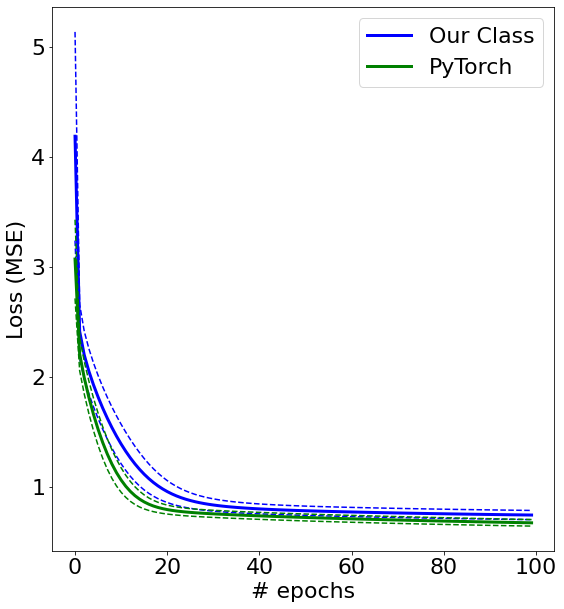

In [9]:
central_our = matrix_loss_our.mean(axis = 1)
up_our = central_our + matrix_loss_our.std(axis = 1)
down_our = central_our - matrix_loss_our.std(axis = 1)

central_pytorch = matrix_loss_pytorch.mean(axis = 1)
up_pytorch = central_pytorch + matrix_loss_pytorch.std(axis = 1)
down_pytorch = central_pytorch - matrix_loss_pytorch.std(axis = 1)

plt.figure(figsize=(9, 10))
plt.plot(range(100), up_our, linewidth = 1.5, linestyle = '--', color = 'b')
plt.plot(range(100), central_our, label = 'Our Class', linewidth = 3, linestyle = '-', color = 'b')
plt.plot(range(100), down_our, linewidth = 1.5, linestyle = '--', color = 'b')

plt.plot(range(100), up_pytorch, linewidth = 1.5, linestyle = '--', color = 'g')
plt.plot(range(100), central_pytorch, label = 'PyTorch', linewidth = 3, linestyle = '-', color = 'g')
plt.plot(range(100), down_pytorch, linewidth = 1.5, linestyle = '--', color = 'g')

plt.xlabel('# epochs', size = 22)
plt.ylabel('Loss (MSE)', size = 22)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)
plt.legend(fontsize = 22)
plt.savefig("loss_plots_2.pdf")
plt.show()

